In [1]:
import numpy as np
import math
import routinglib as rl 

rng = np.random.default_rng()

def UpdateCs(acc_Cs, Ns):
    if np.all(Ns):
        return acc_Cs/Ns
    
    Cs = np.zeros(acc_Cs.shape)
    for i in range(Cs.shape[0]):
        for j in range(Cs.shape[1]):
            Cs[i,j] = acc_Cs[i,j]/Ns[i,j] if Ns[i,j] else 0
    return Cs


def b_ij(C, Ns, a, b, t):
    if Ns[b,a] == 0:
        return 0
    return C[b,a] - (1.5*math.log(t) / Ns[b,a])**0.5

def CombLCB(T, C, E, Path_list):
    n = A.shape[0]
    Cs = np.zeros((n,n))
    Ns = np.zeros((n,n))
    acc_Cs = np.zeros((n,n))
    acc_cost = np.zeros(T)
    
    path_usage = np.zeros(len(Path_list))

    #Perform learning rounds
    for t in range(T):
        best_path = rl.BellmanFordPath(E, Cs, Ns, t, b_ij)
        (C_samples, Ns_samples, path_cost) = rl.UsePathLCB(C,best_path)
        acc_Cs += C_samples
        Ns += Ns_samples
        Cs = UpdateCs(acc_Cs, Ns)
        acc_cost[t] = acc_cost[t-1] + path_cost if t > 0 else path_cost
        r = rl.RankPath(Path_list, best_path)
        path_usage[r] += 1
    
    return (acc_cost, path_usage) 

def ESCB_best_path(E, Cs, Ns, t, paths):
    n = Cs.shape[0]
    inner = np.zeros((n,n))
    for (a,b) in E:
        if Ns[b,a] != 0:
            inner[b,a] = (1.5 * math.log(t)) / Ns[b,a]

    inner = inner.reshape((n*n,1))
            
    Cs = Cs.reshape(n*n,1)
    Csum = paths@Cs

    m = paths.shape[0]
    indexes = np.zeros(m)
    for i in range(m):
        indexes[i] = Csum[i] - (paths[i]@inner)**0.5

    best_index = np.argmin(indexes)
    best_path = paths[best_index]
    return best_path

def ESCB2(T,C,E,Path_list):
    n = C.shape[0]
    paths = rl.PathListAsMatrix(Path_list,n)
    Cs = np.zeros((n,n))
    Ns = np.zeros((n,n))
    acc_Cs = np.zeros((n,n))
    acc_cost = np.zeros(T)
    path_usage = np.zeros(len(Path_list))
    
    for t in range(T):
        best_path = ESCB_best_path(E,Cs,Ns,t,paths)
        (Cs_samples, Ns_samples, path_cost) = rl.UsePathESCB(C,best_path)
        acc_Cs += Cs_samples
        Cs = UpdateCs(acc_Cs, Ns) 
        Ns += Ns_samples
        acc_cost[t] = acc_cost[t-1] + path_cost if t > 0 else path_cost
        
        best_path = rl.PathToList(best_path)
        r = rl.RankPath(Path_list, best_path)
        path_usage[r] += 1
        
    return (acc_cost, path_usage)
    

def TSIndexes(Observations,n):
    indexes = np.zeros(n)
    for i in range(n):
        S = Observations[i][0]
        F = Observations[i][1]
        indexes[i] = rng.beta(S+1, F+1)
    return indexes


def TSCost(Cs, _, a, b, __):
    return rng.beta(Cs[b,a,0]+1, Cs[b,a,1]+1)

def CombTS(T,P,E, Path_list):
    n = A.shape[0]
    Cs = np.zeros((n,n,2)) #Cs[a,b,0]: S_{a,b}, Cs[a,b,1]: F_{a,b}
    acc_cost = np.zeros(T)
    path_usage = np.zeros(len(Path_list))
    
    for t in range(T):
        best_path = rl.BellmanFordPath(E, Cs, _, __, TSCost)
        (Cs_samples, path_cost) = rl.UsePathTS(P,best_path)
        Cs += Cs_samples
        acc_cost[t] = acc_cost[t-1] + path_cost if t > 0 else path_cost
    
        r = rl.RankPath(Path_list, best_path)
        path_usage[r] += 1

    return acc_cost, path_usage




In [2]:
#T: learning rounds
#C: Cost matrix C_ij
#E: List of node pairs
#Path_list: list of tuples ([path],cost) 
#Dest: destination node index
def RunLearning(Algorithm, Repeats, Path_list, T, C, E, Dest):
    #Find best path
    n = C.shape[0]
    cost = np.zeros((Repeats, T))  
    path_usage = np.zeros(len(Path_list))
    best_path, min_cost = rl.GetBestPath(E,C,Dest)
    min_costs = (np.arange(T)+1)*min_cost

    p = (np.arange(10)+1) * 0.1
    for r in range(Repeats):
        r_cost, r_path_usage = Algorithm(T, C, E, Path_list)
        cost[r] = r_cost   
        path_usage += r_path_usage
        t = Repeats/10
        if round(r/Repeats,2) in p:
            print(f'{100 * round(r/Repeats,2)}% done')

    regret = cost - min_costs
    regret_mean = np.mean(regret, axis=0)
    regret_std = np.std(regret, axis=0)
    path_usage = path_usage/Repeats
    return (regret_mean, regret_std, path_usage)



10.0% done
20.0% done
40.0% done
50.0% done
80.0% done
90.0% done
115 paths were never chosen on average during experimentation
10.0% done
20.0% done
40.0% done
50.0% done
80.0% done
90.0% done
311 paths were never chosen on average during experimentation
10.0% done
20.0% done
40.0% done
50.0% done
80.0% done
90.0% done
168 paths were never chosen on average during experimentation


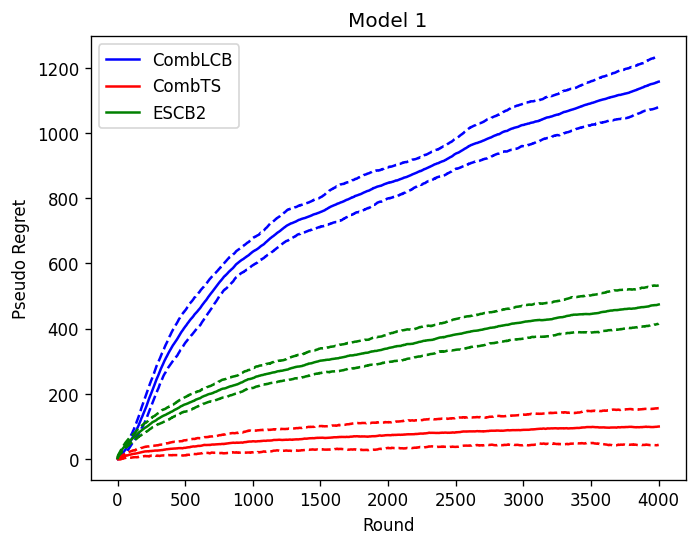

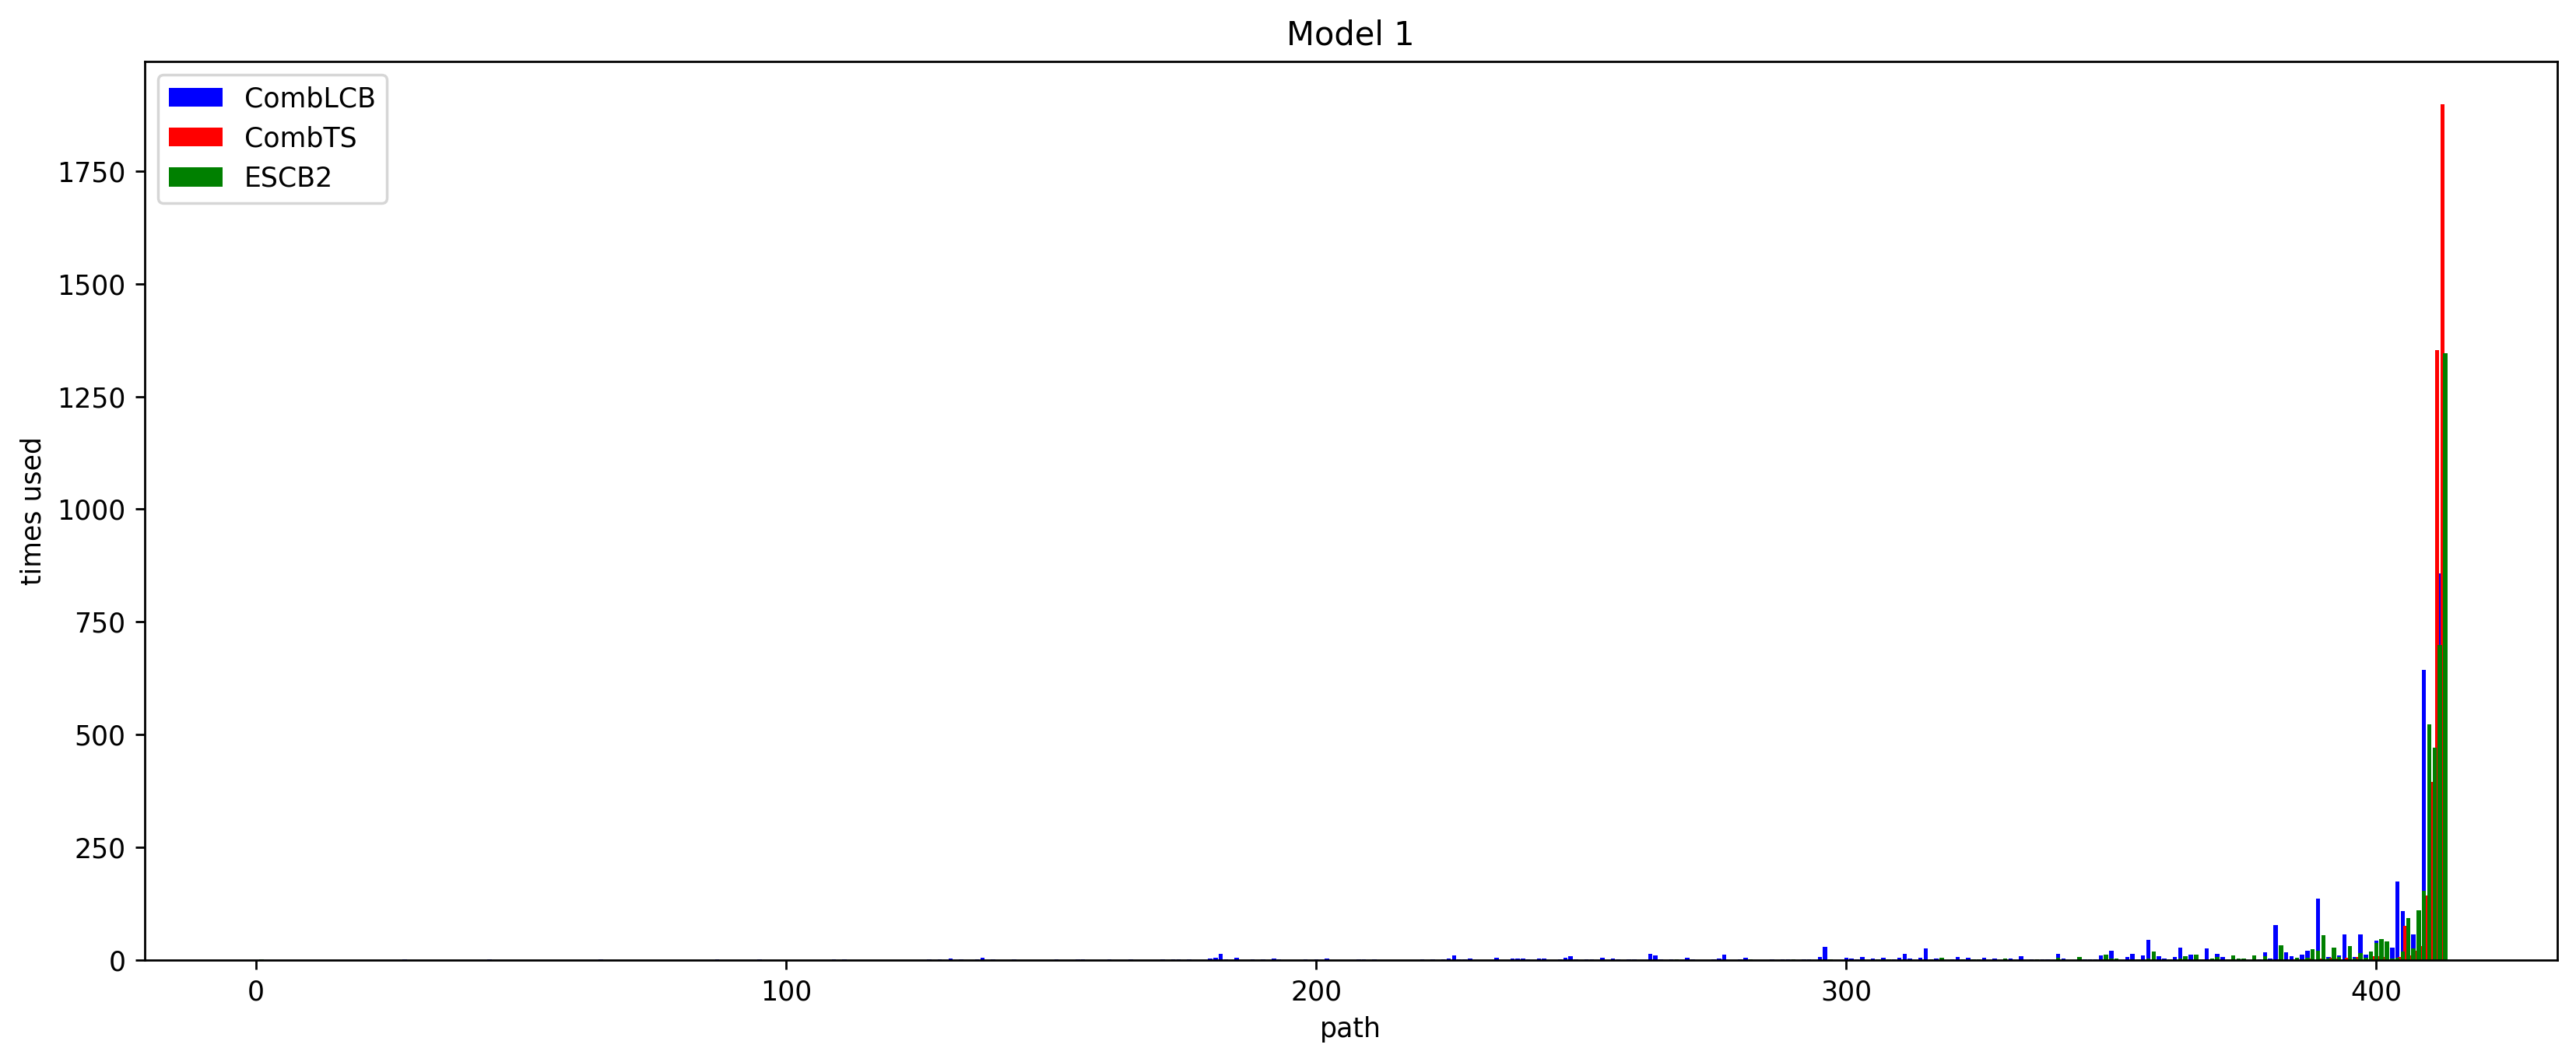

In [3]:
import topology as tp
import matplotlib.pyplot as plt

#Initialize learning setup
T = 4000
Repeats = 40
A = tp.GetNetwork() 
C = tp.GetCosts()
E = rl.GetEdges(A)
Dest = tp.Destination()
Path_list = rl.ListPaths(A,C)
Algorithms = [CombLCB, CombTS, ESCB2]
AlgorithmLabels = ['CombLCB', 'CombTS', 'ESCB2']
colors = ['blue', 'red', 'green']

plt.figure(1, dpi=120)
plt.title("Model 1")
plt.figure(2, figsize=(16,6), dpi=250)
plt.title("Model 1")

#Run learning for all algorithms
for i in range(len(Algorithms)):
    Regret, Regret_std, Path_usage = RunLearning(   Algorithms[i],
                                                    Repeats,
                                                    Path_list,
                                                    T,C,E, Dest)

    not_used = 0
    for index in Path_usage:
        if index == 0:
            not_used += 1

    print(f'{not_used} paths were never chosen on average during experimentation')

    plt.figure(1)
    x = np.arange(T) + 1
    plt.plot(x,Regret, color=colors[i], label=AlgorithmLabels[i])
    plt.plot(x,Regret-Regret_std, '--', color=colors[i])
    plt.plot(x,Regret+Regret_std, '--', color=colors[i])

    plt.figure(2)
    x2 = np.arange(len(Path_usage))
    plt.bar(x2+i/2,Path_usage, color=colors[i], label=AlgorithmLabels[i])


plt.figure(1)
plt.xlabel('Round')
plt.ylabel('Pseudo Regret')
plt.legend(loc='upper left')
plt.figure(2)
plt.xlabel('path')
plt.ylabel('times used')
plt.legend(loc='upper left')

plt.show()